# ShanghaiTech Anomaly Detection

## Overview
This notebook contains the final implementation of the overcrowding detection system for the ShanghaiTech Dataset.

## Setup
Import dependencies and configure the environment.

In [2]:
import os
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

def generate_density_map(img, points, sigma=15):
    density = np.zeros(img.shape[:2], dtype=np.float32)
    h, w = density.shape

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))
        density[y, x] += 1
    
    return gaussian_filter(density, sigma=sigma)

def load_gt_mat(mat_path):
    mat = scipy.io.loadmat(mat_path)
    return mat["image_info"][0][0][0][0][0]

def process_images_and_save_density_maps(image_dir, gt_dir, output_density_dir):
    os.makedirs(output_density_dir, exist_ok=True)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

    for img_file in tqdm(sorted(image_files)):
        img_path = os.path.join(image_dir, img_file)
        gt_path = os.path.join(gt_dir, f"GT_{img_file.replace('.jpg', '.mat')}")
        output_path = os.path.join(output_density_dir, img_file.replace('.jpg', '.npy'))

        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        points = load_gt_mat(gt_path)
        density = generate_density_map(img, points)
        np.save(output_path, density)

        # Optional: visualize a few maps
        # if np.random.rand() < 0.05:
        #     plt.imshow(density, cmap='jet')
        #     plt.title(img_file)
        #     plt.show()

# Set your paths
base = "datasets/ShanghaiTech/part_A"
train_img = os.path.join(base, "train_data/images")
train_gt = os.path.join(base, "train_data/ground-truth")
train_den = os.path.join(base, "train_data/density")

test_img = os.path.join(base, "test_data/images")
test_gt = os.path.join(base, "test_data/ground-truth")
test_den = os.path.join(base, "test_data/density")

# Run processing
process_images_and_save_density_maps(train_img, train_gt, train_den)
process_images_and_save_density_maps(test_img, test_gt, test_den)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

## Model Definitions

In [2]:
import os
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

def generate_density_map(img, points, sigma=15):
    density = np.zeros(img.shape[:2], dtype=np.float32)
    h, w = density.shape

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))
        density[y, x] += 1
    
    return gaussian_filter(density, sigma=sigma)

def load_gt_mat(mat_path):
    mat = scipy.io.loadmat(mat_path)
    return mat["image_info"][0][0][0][0][0]

def process_images_and_save_density_maps(image_dir, gt_dir, output_density_dir):
    os.makedirs(output_density_dir, exist_ok=True)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

    for img_file in tqdm(sorted(image_files)):
        img_path = os.path.join(image_dir, img_file)
        gt_path = os.path.join(gt_dir, f"GT_{img_file.replace('.jpg', '.mat')}")
        output_path = os.path.join(output_density_dir, img_file.replace('.jpg', '.npy'))

        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        points = load_gt_mat(gt_path)
        density = generate_density_map(img, points)
        np.save(output_path, density)

        # Optional: visualize a few maps
        # if np.random.rand() < 0.05:
        #     plt.imshow(density, cmap='jet')
        #     plt.title(img_file)
        #     plt.show()

# Set your paths
base = "datasets/ShanghaiTech/part_A"
train_img = os.path.join(base, "train_data/images")
train_gt = os.path.join(base, "train_data/ground-truth")
train_den = os.path.join(base, "train_data/density")

test_img = os.path.join(base, "test_data/images")
test_gt = os.path.join(base, "test_data/ground-truth")
test_den = os.path.join(base, "test_data/density")

# Run processing
process_images_and_save_density_maps(train_img, train_gt, train_den)
process_images_and_save_density_maps(test_img, test_gt, test_den)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torch.utils.data import ConcatDataset
from torch.optim.lr_scheduler import StepLR


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------------
# Custom Dataset for Crowd Counting
# --------------------------------------------------
class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, transform=None):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        den_path = os.path.join(self.den_dir, self.images[idx].replace(".jpg", ".npy"))

        image = Image.open(img_path).convert("RGB")
        density = np.load(den_path)  # shape: (H, W)

        if self.transform:
            image = self.transform(image)

        density = cv2.resize(density, (512, 384), interpolation=cv2.INTER_CUBIC)
        density = torch.tensor(density, dtype=torch.float32).unsqueeze(0)

        return image, density
# --------------------------------------------------
# VGG-based CSRNet model
# --------------------------------------------------
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])  # up to conv4_3
        self.backend = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)  # output 1-channel density map
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return F.relu(x)

# --------------------------------------------------
# Training Setup
# --------------------------------------------------
transform = transforms.Compose([
    transforms.RandomResizedCrop((384, 512), scale=(0.9, 1.0)),  # Zoom-like crop
    transforms.RandomHorizontalFlip(),                           # Flip for augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset_A = CrowdDataset(
    img_dir="datasets/ShanghaiTech/part_A/train_data/images",
    den_dir="datasets/ShanghaiTech/part_A/train_data/density",
    transform=transform
)

train_dataset_B = CrowdDataset(
    img_dir="datasets/ShanghaiTech/part_B/train_data/images",
    den_dir="datasets/ShanghaiTech/part_B/train_data/density",
    transform=transform
)

combined_dataset = ConcatDataset([train_dataset_A, train_dataset_B])
train_loader = DataLoader(combined_dataset, batch_size=4, shuffle=True)

model = CSRNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Every 30 epochs, reduce LR
criterion = nn.MSELoss()

# --------------------------------------------------
# Train Loop (small for testing)
# --------------------------------------------------
for epoch in range(100):
    model.train()
    total_loss = 0
    for img, den in train_loader:
        img, den = img.to(DEVICE), den.to(DEVICE)
        pred = model(img)

        # Match output size: crop or interpolate if needed
        if pred.shape != den.shape:
            pred = F.interpolate(pred, size=den.shape[-2:], mode="bilinear", align_corners=False)

        loss = criterion(pred, den)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
torch.save(model.state_dict(), "csrnet_shanghai.pt")

Epoch 1, Loss: 0.0233
Epoch 2, Loss: 0.0017
Epoch 3, Loss: 0.0017
Epoch 4, Loss: 0.0017
Epoch 5, Loss: 0.0017
Epoch 6, Loss: 0.0017
Epoch 7, Loss: 0.0017
Epoch 8, Loss: 0.0017
Epoch 9, Loss: 0.0017
Epoch 10, Loss: 0.0017
Epoch 11, Loss: 0.0017
Epoch 12, Loss: 0.0017
Epoch 13, Loss: 0.0017
Epoch 14, Loss: 0.0017
Epoch 15, Loss: 0.0017
Epoch 16, Loss: 0.0017
Epoch 17, Loss: 0.0017
Epoch 18, Loss: 0.0017
Epoch 19, Loss: 0.0017
Epoch 20, Loss: 0.0017
Epoch 21, Loss: 0.0017
Epoch 22, Loss: 0.0017
Epoch 23, Loss: 0.0017
Epoch 24, Loss: 0.0017
Epoch 25, Loss: 0.0017
Epoch 26, Loss: 0.0017
Epoch 27, Loss: 0.0017
Epoch 28, Loss: 0.0017
Epoch 29, Loss: 0.0017
Epoch 30, Loss: 0.0017
Epoch 31, Loss: 0.0017
Epoch 32, Loss: 0.0017
Epoch 33, Loss: 0.0017
Epoch 34, Loss: 0.0017
Epoch 35, Loss: 0.0017
Epoch 36, Loss: 0.0017
Epoch 37, Loss: 0.0017
Epoch 38, Loss: 0.0017
Epoch 39, Loss: 0.0017
Epoch 40, Loss: 0.0017
Epoch 41, Loss: 0.0017
Epoch 42, Loss: 0.0017
Epoch 43, Loss: 0.0017
Epoch 44, Loss: 0.00

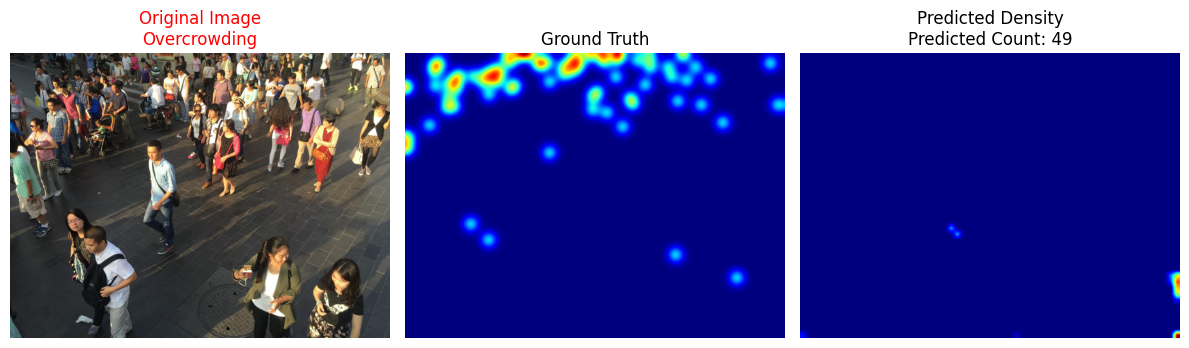

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

def get_alert_level(count):
    if count <= 5:
        return "Normal", "green"
    elif count <= 10:
        return "Can lead to overcrowding", "yellow"
    elif count <= 20:
        return "Possible overcrowding", "orange"
    else:
        return "Overcrowding", "red"

# Example frame
img_path = "datasets/ShanghaiTech/part_B/test_data/images/IMG_47.jpg"
den_path = "datasets/ShanghaiTech/part_B/test_data/density/IMG_47.npy"

image = Image.open(img_path).convert("RGB")
gt_density = np.load(den_path)

input_img = transform(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    output = model(input_img)
    output = output.squeeze().cpu().numpy()
    output = cv2.resize(output, (gt_density.shape[1], gt_density.shape[0]))

# Count
pred_count = output.sum()
alert_text, alert_color = get_alert_level(pred_count)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title(f"Original Image\n{alert_text}", color=alert_color)
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(gt_density, cmap='jet')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Predicted Density\nPredicted Count: {pred_count:.0f}")
plt.imshow(output, cmap='jet')
plt.axis("off")

plt.tight_layout()
plt.show()

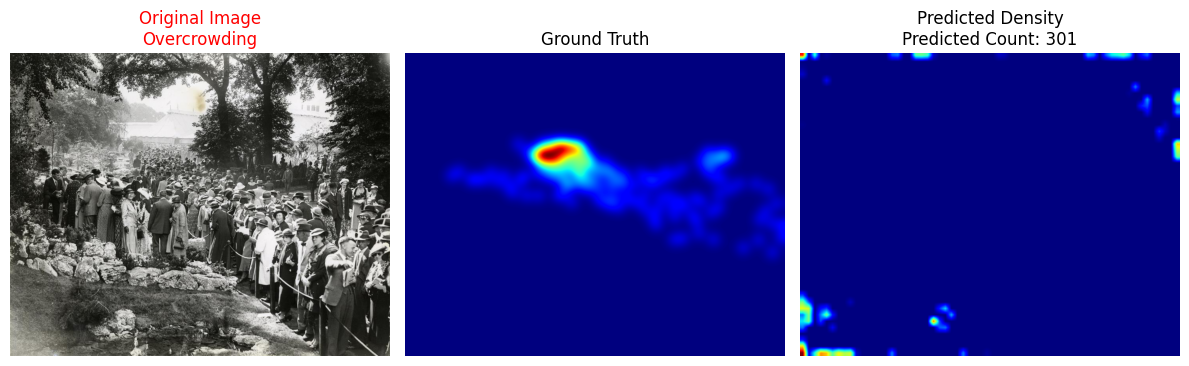

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

def get_alert_level(count):
    if count <= 5:
        return "Normal", "green"
    elif count <= 10:
        return "Can lead to overcrowding", "yellow"
    elif count <= 20:
        return "Possible overcrowding", "orange"
    else:
        return "Overcrowding", "red"

# Example frame
img_path = "datasets/ShanghaiTech/part_A/test_data/images/IMG_101.jpg"
den_path = "datasets/ShanghaiTech/part_A/test_data/density/IMG_101.npy"

image = Image.open(img_path).convert("RGB")
gt_density = np.load(den_path)

input_img = transform(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    output = model(input_img)
    output = output.squeeze().cpu().numpy()
    output = cv2.resize(output, (gt_density.shape[1], gt_density.shape[0]))

# Count
pred_count = output.sum()
alert_text, alert_color = get_alert_level(pred_count)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title(f"Original Image\n{alert_text}", color=alert_color)
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(gt_density, cmap='jet')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Predicted Density\nPredicted Count: {pred_count:.0f}")
plt.imshow(output, cmap='jet')
plt.axis("off")

plt.tight_layout()
plt.show()

In [27]:
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model = CSRNet().to(DEVICE)
model.load_state_dict(torch.load("csrnet_shanghai.pt", map_location=DEVICE))
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Count-based label function
def get_crowd_label(count):
    if count < 5:
        return "Normal", (0, 255, 0)
    elif 5 <= count < 10:
        return "Can Lead to Overcrowding", (0, 255, 255)
    elif 10 <= count < 20:
        return "Possible Overcrowding", (255, 165, 0)
    else:
        return "Overcrowding", (255, 0, 0)

# Input/Output
video_path = "test.mp4"  # 
output_path = "test_output_overcrowding_alert.mp4"

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

print("Processing video...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(input_tensor)
        pred = pred.squeeze().cpu().numpy()
        pred = cv2.resize(pred, (w, h))
        count = int(pred.sum())

    label_text, color = get_crowd_label(count)
    display_text = f"{label_text} | Count: {count}"

    # Draw overlay
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)
    cv2.rectangle(frame, (5, 5), (w - 5, h - 5), color, 2)

    out.write(frame)

cap.release()
out.release()
print("Done! Saved to:", output_path)

/var/folders/s9/w1f1my553ll2rpzvjc_kqfx80000gn/T/ipykernel_63237/3125677391.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("csrnet_sha

Processing video...
Done! Saved to: test_output_overcrowding_alert.mp4


## Inference

In [1]:
pip install scipy h5py opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Set your paths
base = "datasets/ShanghaiTech/part_B"
train_img = os.path.join(base, "train_data/images")
train_gt = os.path.join(base, "train_data/ground-truth")
train_den = os.path.join(base, "train_data/density")

test_img = os.path.join(base, "test_data/images")
test_gt = os.path.join(base, "test_data/ground-truth")
test_den = os.path.join(base, "test_data/density")

# Run processing
process_images_and_save_density_maps(train_img, train_gt, train_den)
process_images_and_save_density_maps(test_img, test_gt, test_den)

100%|█████████████████████████████████████████| 316/316 [00:14<00:00, 21.22it/s]
